In [2]:
from contrastive_data import *
from data_utils import *
from main import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.io import mmread

# Loading Ursu's data

In [2]:
GENE = 'TP53'
data_path = f'/home/lguirardel/data/perturb_comp/data/{GENE}/'
data_type = 'processed' # 'raw' or 'processed'


In [3]:
group_wt_like = False
paths = get_paths(data_path, subset=data_type)
counts = load_data(*paths, group_wt_like=group_wt_like)

	Reading files...
		Reading matrix
		Reading genes and cells
		Reading variant data
	Merging and processing...
		99 variant classes


In [4]:
variant_data = pd.read_csv(paths[4], index_col=0)
variant_data.loc['control'] = pd.Series({'Control status':'synonymous','Variant functional class':'WT-like'})

In [5]:
with gzip.open(paths[3]) as file: # read cell tags
    v2c = pd.read_csv(file, sep='\t', usecols=['cell','variant'], index_col=1).squeeze()
v2c = v2c[counts.index]

In [6]:
df_ursu = counts[counts['variant'].isin(['R175H', 'L344L'])].copy()
df_ursu['variant'] = df_ursu['variant'].cat.remove_unused_categories()
df_ursu.groupby('variant').size() # remove unused cats

variant
L344L     918
R175H    1000
dtype: int64

In [7]:
y_ursu = df_ursu['variant']
x_ursu = df_ursu.iloc[:, :-3]

# Reading Nabids data

In [5]:
nabid_path = '/home/lguirardel/data/nabid_data/p53pilot/Data/'

In [5]:
with open(nabid_path + 'RawData/filtered_feature_bc_matrix/matrix.mtx') as file:
    mtx = mmread(file)

In [6]:
genes = pd.read_csv(nabid_path + 'RawData/filtered_feature_bc_matrix/features.tsv', sep='\t', header=None, names=['gene_id','gene_name','type'])['gene_id']
cells = pd.read_csv(nabid_path + 'RawData/filtered_feature_bc_matrix/barcodes.tsv', header=None, names=['cell']).squeeze()
x_nabid = pd.DataFrame(mtx.todense().T, columns=genes, index=cells)

In [11]:
meta_nabid = pd.read_csv(nabid_path + 'MetaData/p53.meta.data.cell.type.csv', index_col=0)

In [12]:
f = x_nabid.index.intersection(meta_nabid.index)
x_nabid = x_nabid.loc[f]
meta_nabid = meta_nabid.loc[f]

In [13]:
x_nabid = x_nabid.loc[meta_nabid['WTvsMutant'].isin(['R175H','WT'])]
y_nabid = meta_nabid.loc[meta_nabid['WTvsMutant'].isin(['R175H','WT'])]['WTvsMutant']

In [14]:
y_nabid.value_counts()

WTvsMutant
WT       1587
R175H    1275
Name: count, dtype: int64

# Wrangling Nabid's data to the Ursu format

In [3]:
conditions = pd.read_csv('~/data/nabid_data/p53pilot/Data/conditions.csv', index_col=0)
barcodes = pd.read_csv('~/data/nabid_data/p53pilot/Data/MetaData/p53.meta.data.cell.type.csv', index_col=0)

In [4]:
genes = pd.read_csv(nabid_path + 'RawData/filtered_feature_bc_matrix/features.tsv', sep='\t', header=None, names=['gene_id','gene_name','type'])

NameError: name 'nabid_path' is not defined

In [16]:
f = genes.gene_name.value_counts() > 1
genes[genes.gene_name.isin(f[f].index)]

,gene_id,gene_name,type
3235,ENSG00000285053,TBCE,Gene Expression
3237,ENSG00000284770,TBCE,Gene Expression
5946,ENSG00000237940,LINC01238,Gene Expression
5950,ENSG00000261186,LINC01238,Gene Expression
6504,ENSG00000114395,CYB561D2,Gene Expression
6507,ENSG00000271858,CYB561D2,Gene Expression
10565,ENSG00000280987,MATR3,Gene Expression
10567,ENSG00000015479,MATR3,Gene Expression
16988,ENSG00000234323,LINC01505,Gene Expression
16992,ENSG00000234229,LINC01505,Gene Expression


In [6]:
barcodes.head()

,orig.ident,nCount_RNA,nFeature_RNA,cell_type,WTvsMutant
AAACCCAGTATCTCTT-1,pilot.v6.cell.types,31037,5767,R175H.P53.BC8,R175H
AAACCCAGTCGCTCGA-1,pilot.v6.cell.types,15175,3898,EV.BC9,Control
AAACCCAGTGACAACG-1,pilot.v6.cell.types,69602,8428,NaN,Unknown
AAACCCAGTGTTACTG-1,pilot.v6.cell.types,4425,1871,P53.BC3,WT
AAACCCATCAGGGTAG-1,pilot.v6.cell.types,38025,5726,NaN,Unknown


In [16]:
barcodes['cell_type'].reset_index().rename(columns={'index':'cell','cell_type':'variant'}).dropna()\
    .to_csv('~/data/nabid_data/p53pilot/Data/RawData/filtered_feature_bc_matrix/wrangled/nabid_tp53.variants2cell.csv', index=True, sep='\t')

In [22]:
counts.columns

Index(['A1BG', 'AATF', 'ABCA1', 'ABCD4', 'ABCG2', 'AC006262.5', 'AC009133.12',
       'AC093673.5', 'ACAT2', 'ACTA2',
       ...
       'ZFP36L1', 'ZFPM1', 'ZMAT3', 'ZNF281', 'ZNF326', 'ZNF467', 'ZNF703',
       'cycle', 'variant', 'Variant functional class'],
      dtype='object', length=1227)

In [6]:
vfc = pd.DataFrame(barcodes.cell_type.unique(), columns = ['Variant']).dropna()
vfc['Variant functional class'] = vfc['Variant'].str.contains('R175H').replace({True:'Impactful II', False:'WT-like'})
vfc.loc[vfc.Variant.isin(['eGFP','EV.BC9']),'Variant functional class'] = 'Control'
# vfc['Variant'] = vfc.Variant.str.replace('R175H.', '')
vfc.to_csv('~/data/nabid_data/p53pilot/Data/RawData/filtered_feature_bc_matrix/nabid_tp53.variants.csv', index=False, sep=',')

In [7]:
vfc

,Variant,Variant functional class
0,R175H.P53.BC8,Impactful II
1,EV.BC9,Control
3,P53.BC3,WT-like
4,P53.BC2,WT-like
5,R175H.P53.BC5,Impactful II
6,eGFP,Control
7,P53.BC4,WT-like
8,R175H.P53.BC7,Impactful II
9,P53.BC1,WT-like
10,R175H.P53.BC6,Impactful II


In [34]:
meta = pd.DataFrame({'phase.multi':'Unknown', 'cell':barcodes.index})
meta.to_csv('~/data/nabid_data/p53pilot/Data/RawData/filtered_feature_bc_matrix/nabid_tp53.metadata.csv', index=False, sep=',')

# Classifiers

In [15]:
random_state = 42

In [16]:
N = 900
x_nabid = x_nabid.sample(N, random_state=random_state)
y_nabid = y_nabid.loc[x_nabid.index]
x_ursu = x_ursu.sample(N, random_state=random_state)
y_ursu = y_ursu.loc[x_ursu.index]

In [20]:
ursu_cls = LogisticRegression(random_state=random_state, max_iter=1000)
nabid_cls = Pipeline([
    ('norm',StandardScaler()), 
    ('cls',LogisticRegression(random_state=random_state, max_iter=1000))]
)

In [21]:
cv_ursu = cross_val_score(ursu_cls, x_ursu, y_ursu, cv=5)
cv_ursu

/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lguirardel/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

array([0.66666667, 0.67222222, 0.7       , 0.66666667, 0.73333333])

In [22]:
cv_nabid = cross_val_score(nabid_cls, x_nabid, y_nabid, cv=5)
cv_nabid

array([0.89444444, 0.87777778, 0.92222222, 0.9       , 0.88333333])

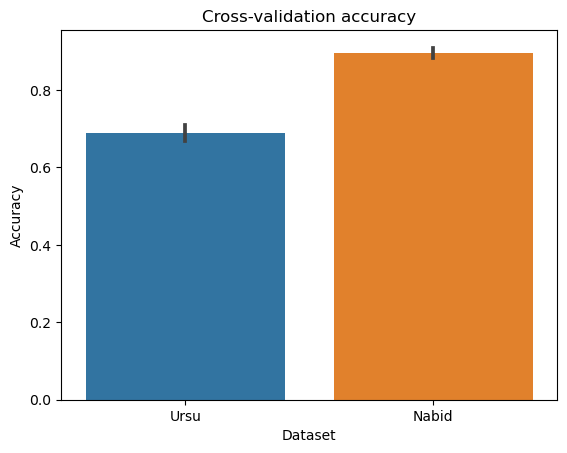

In [25]:
# score bar plot
scores = pd.DataFrame({'Ursu':cv_ursu, 'Nabid':cv_nabid})
scores = scores.melt(var_name='Dataset', value_name='Accuracy')
sns.barplot(data=scores, x='Dataset', y='Accuracy')
plt.title('Cross-validation accuracy')
plt.savefig(f'plots/scores/{GENE}_nabid_vs_ursu_{data_type}.pdf')
plt.show() 

In [ ]:
x_nabid.shape

(900, 36601)

In [ ]:
x_ursu.shape

(900, 1224)

## Data split

## Normalizing Nabids data